# Visualizing and Analyzing the Distribution of Impact Hours

## This part was done by @ygg_anderson

In [1]:
import pandas as pd
import hvplot.pandas

In [2]:
import os

In [3]:
sheet_name="Total Impact Hours so far"
header=1
index_col=0
usecols=None

data = pd.read_excel(
    "data/TEC Praise Quantification.xlsx",
    sheet_name="Total Impact Hours so far",
    engine='openpyxl',
    header=header,
    index_col=index_col,
    usecols=usecols
).reset_index().dropna(how='any')

In [4]:
data['Impact Hours'].sum()

data['% of distribution'] = data['Impact Hours'] / data['Impact Hours'].sum()

data.hvplot.area(y='Impact Hours', title='Impact Hours Distribution')

:Area   [index]   (Impact Hours)

## This part was done by @🐙octopus

In [5]:
data['Impact Hours'].describe()

count    384.000000
mean      22.241910
std       57.420886
min        0.025141
25%        1.048139
50%        3.296551
75%       16.104496
max      598.058166
Name: Impact Hours, dtype: float64

**Comment:** From the histogram above, this is obviously a very right-skewed distribution. It has a median of 3.29551 and a mean of 16.104496. 

**Question:** In a classical Pareto distribution, the top 20% of the population has 80% of the wealth. How does this distribution compare? 

In [6]:
import numpy as np

Now we write a function to compute the percentage of Impact Hours awarded to the top $p$ percent of the population. 

In [7]:
def resources_percentage(p):
    relevant_percentile = np.percentile(data['Impact Hours'],p)
    is_gt_relevant_percentile = data['Impact Hours'] > relevant_percentile
    filtered_data = data[is_gt_relevant_percentile]
    filtered_hours = filtered_data['Impact Hours']
    pct_hours = filtered_hours.sum()/data['Impact Hours'].sum()
    return pct_hours

for p in [50,80,90,95,99]:
    print("The top {} percent of the population".format(100-p))
    print("received {:0.2f} percent of the Impact Hours \n \n".format(resources_percentage(p)))

The top 50 percent of the population
received 0.97 percent of the Impact Hours 
 

The top 20 percent of the population
received 0.84 percent of the Impact Hours 
 

The top 10 percent of the population
received 0.66 percent of the Impact Hours 
 

The top 5 percent of the population
received 0.50 percent of the Impact Hours 
 

The top 1 percent of the population
received 0.21 percent of the Impact Hours 
 



Text(0.5, 1.0, 'Cumulative Distribution Function for Impact Hours')

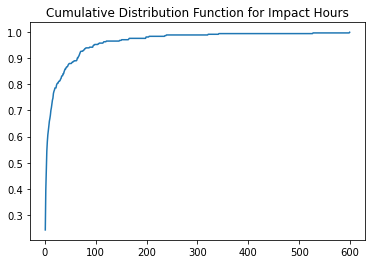

In [8]:
import seaborn as sns

def cum_dist(val): #cumulative distribution function
    prob_lt_val = (data['Impact Hours'] < val).mean() #you can get proportions by taking average of boolean values
    return prob_lt_val

pct_values = np.arange(1,600)
cum_dist_values = [cum_dist(p) for p in pct_values]

sns.lineplot(x = pct_values, y = cum_dist_values).set_title("Cumulative Distribution Function for Impact Hours")

Text(0.5, 1.0, 'Cumulative Distribution Function (Actual vs. Pareto with Shape Parameter b = 0.65)')

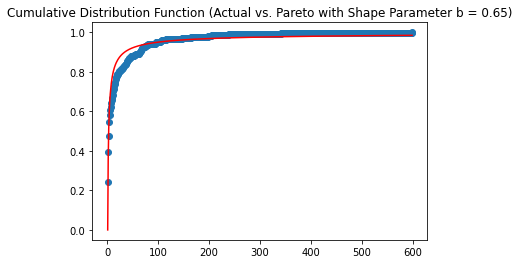

In [9]:
import matplotlib.pyplot as plt
import scipy.stats as ss

pareto_rv = ss.pareto(0.65)

plt.scatter(x = pct_values, y = cum_dist_values)
plt.plot(pct_values,[pareto_rv.cdf(p) for p in pct_values], color = 'red')
plt.title("Cumulative Distribution Function (Actual vs. Pareto with Shape Parameter b = 0.65)")

## Gini Coefficient 

Some basic facts on [Gini Coefficient](https://www.investopedia.com/terms/g/gini-index.asp):
* The *Gini Coefficient* is a measure of inequality in a population, typically for income or wealth
* For non-negative data, the Gini Coefficient will be a number between 0.0 and 1.0
* The Gini Coefficient would be 0.0 if everyone received exactly the same amount
* The Gini Coefficient would be exactly 1.0 if one person received everything
* The United Nations has set a "warning level" for national income of 0.4; if a nation has Gini Coefficient for income distribution greater than 0.4, it is considered highly unequal. 

The calculation of the Gini Coefficient for a discrete distribution (like we have here) can be calculated as:
$$G = \displaystyle\frac{\sum_{i=1^n} \sum_{j = 1}^n |x_i - x_j|}{2n^2 \overline{x}}$$

where $n$ is the number of observations, $x_k$ represents the $k$th observation in the data set, and $\overline{x}$ is the mean of the data. 
n  b

### Let's define a function to calculate the Gini Coefficent. 

In [10]:
def gini_coefficient(x):
    n = len(x)
    x_bar = np.mean(x)
    abs_diffs = np.array([np.sum(np.abs(x[i] - x)) for i in range(n)])
    sum_abs_diffs = np.sum(abs_diffs)
    denominator = 2*n*n*x_bar
    return sum_abs_diffs/denominator

In [11]:
print("The Gini Coefficient of the Impact Hours distribtion is {:0.2f}".format(gini_coefficient(data["Impact Hours"])))

The Gini Coefficient of the Impact Hours distribtion is 0.79


The Gini Coefficient of the Impact Hours distribution is higher than that of any country in the world (for comparison's sake, the highest income Gini Coefficient is between 0.6 and 0.65 -- see https://upload.wikimedia.org/wikipedia/commons/b/b1/GINI_index_World_Bank_up_to_2018.svg)

This may not be a fair comparison. Some people have made the TEC their life, while others have attended one meeting. Let us run the analysis again for only subsets of users, to ignore those who may have made very minimal contributions. 

In [12]:
top50pct = data["Impact Hours"][data["Impact Hours"] > data["Impact Hours"].median()]
print("The Gini Coefficient for the top 50% of contributors is {:0.2f}".format(gini_coefficient(top50pct)))

The Gini Coefficient for the top 50% of contributors is 0.64


In [13]:
top20pct = data["Impact Hours"][data["Impact Hours"] > np.quantile(data["Impact Hours"],0.8)]
print("The Gini Coefficient for the top 20% of contributors is {:0.2f}".format(gini_coefficient(top20pct)))

The Gini Coefficient for the top 20% of contributors is 0.44


### How would UBI impact the Distribution? 

Currently, the user with the most Impact Hours has about 60000 times as many as the user with the least. Adding a base amount of Impact Hours to all users would change this. For instance, if all users received 600 Impact Hours as a basline, then the "richest" user would have about twice as many Impact Hours as the "poorest".

The question is raised of how a **Universal Basic Income**-style shift would impact the Gini Coefficient. We can answer this one. We assume a minimum UBI of 0.5 Impact Hours, and a maximum of 100. 

Text(0.5, 1.0, 'Gini Coefficient vs. UBI')

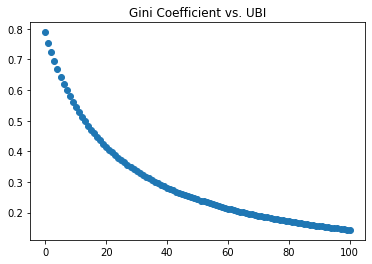

In [14]:
possible_UBI_values = np.arange(0,100.5)
new_gini_coefficients = [gini_coefficient(data["Impact Hours"] + val) for val in possible_UBI_values]
plt.scatter(possible_UBI_values, new_gini_coefficients)
plt.title("Gini Coefficient vs. UBI")

### Other Potential Metrics and Interventions 

The Gini coefficient is one measure of inequality in a distribution. There are many others both simple (consider, for instance, ratios between quantities such as maximum, minimum, median, mean, etc.) and intricate (such as comparing to predictions made by preferential attachment models). Note also that inequality of outcome is not automatically unfair. 

Universal Basic Income is one strategy for addressing inequailty, should such an intervention be desired. There are infinitely many othrs (any mahtematical function will change the distribution). 

Rather than try to generate all possible  tools for measurement or modification, it would likely be better for the community to discuss ideal distributions, including simple specific scenarios. Different approaches could then be compared on the basis of how well they produced the community's desired outcomes under well-understood scenarios. 

Of course, it is also possible that everything is fine, in which case I hope you enjoyed the graphs. Thank you for reading. 


### Extensions By YGG
I would like to make an interactive widget here. Let's sample the top p percent and see how that changes the distribution. Let's also apply a UBI u. What about a non-linear UBI? How about the gaussian function.

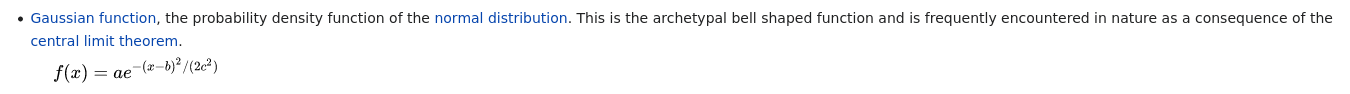

In [15]:
data['% of distribution'] = data['Impact Hours'] / data['Impact Hours'].sum()

In [16]:
import param as pm
import panel as pn
import holoviews as hv
import scipy.stats as ss
import warnings
warnings.filterwarnings('ignore')

In [17]:
class DistributionInterventions(pm.Parameterized):
    top_percent_hatchers = pm.Number(0.5, bounds=(0,1), step=0.01)
    ubi = pm.Number(25, bounds=(0, 100), step=1)
    pareto_beta = pm.Number(0.4, bounds=(0,1), step=0.01)
    
    def __init__(self, data, **params):
        super(DistributionInterventions, self).__init__(**params)
        self.original_data = data
        self.data = data.copy()
        self.add_ubi()
        
        
    @pm.depends('ubi', watch=True)    
    def add_ubi(self):
        self.data['Impact Hours'] = self.original_data['Impact Hours'] + self.ubi
        
    def filtered_data(self):
        data = self.data.iloc[:round(len(self.data)*self.top_percent_hatchers)]
        data['% of distribution'] = data['Impact Hours'] / data['Impact Hours'].sum()
        return data
        
    def total_impact_hours(self):
        return pn.Column(
            pn.Row(pn.Column(
                "Filtered Impact Hours:", 
                round(self.filtered_data()['Impact Hours'].sum(), 2),
                ), pn.Column(
                "Percent of total Impact Hours:", 
                round(self.filtered_data()['Impact Hours'].sum() / self.data['Impact Hours'].sum(), 2),
                )),
            "Summary:",
            self.filtered_data()['Impact Hours'].describe(),
        )

    def percent_line(self):
        return hv.VLine(len(self.data)*self.top_percent_hatchers, color='red').opts(hv.opts.VLine(color='red'))

    def distribution(self):
        return (self.filtered_data().hvplot.area(y='Impact Hours', title='Impact Hours Distribution') * self.data.hvplot.line(y='Impact Hours', title='Impact Hours Distribution') * self.percent_line()).opts(shared_axes=False)

    def cum_dist(self, val): #cumulative distribution function
        prob_lt_val = (self.filtered_data()['Impact Hours'] < val).mean() # you can get proportions by taking average of boolean values
        return prob_lt_val
    
    def filtered_pareto(self):
        pct_values = np.arange(self.filtered_data()['Impact Hours'].min(),self.filtered_data()['Impact Hours'].max())
        cum_dist_values = [self.cum_dist(p) for p in pct_values]

        pareto_rv = ss.pareto(self.pareto_beta)
        pareto = [pareto_rv.cdf(p) for p in range(len(pct_values))]

        distributions = pd.DataFrame(zip(cum_dist_values, pareto), columns=['IH Cumulative Distribution', f'Pareto Distribution beta={self.pareto_beta}'])
        
        return distributions.hvplot.line().opts(hv.opts.VLine(color='red')).opts(shared_axes=False)
    
    def resources_percentage(self, p):
        data = self.filtered_data()
        relevant_percentile = np.percentile(data['Impact Hours'],p)
        is_gt_relevant_percentile = data['Impact Hours'] > relevant_percentile
        filtered_data = data[is_gt_relevant_percentile]
        filtered_hours = filtered_data['Impact Hours']
        pct_hours = filtered_hours.sum()/data['Impact Hours'].sum()
        return pct_hours

    def view_resources_percentage(self):
        message = ""
        for p in [50,80,90,95,99]:
            message += "The top {} percent of the population\n".format(100-p)
            message += "received {:0.2f} percent of the Impact Hours \n \n".format(self.resources_percentage(p))
            
        return pn.Pane(message)
    
    def gini_coefficient(self):
        x = self.filtered_data()['Impact Hours'].values
        n = len(x)
        x_bar = np.mean(x)
        abs_diffs = np.array([np.sum(np.abs(x[i] - x)) for i in range(n)])
        sum_abs_diffs = np.sum(abs_diffs)
        denominator = 2*n*n*x_bar
        return sum_abs_diffs/denominator
    
    def view_data(self):
        return self.filtered_data().head(10)

In [19]:
d = DistributionInterventions(data)
pn.Column(
    pn.Row(d, d.total_impact_hours, d.distribution), 
    pn.Row(d.view_data, pn.Column(d.view_resources_percentage, "GINI Coefficient of filtered data", d.gini_coefficient)),
)

Column
    [0] Row
        [0] Column(margin=5, name='DistributionInterventions..., width=300)
            [0] StaticText(value='<b>DistributionInterventi...)
            [1] FloatSlider(name='Top percent hatchers', step=0.01, value=0.5)
            [2] FloatSlider(end=100, name='Ubi', step=1, value=25)
            [3] FloatSlider(name='Pareto beta', step=0.01, value=0.4)
        [1] ParamMethod(method)
        [2] ParamMethod(method)
    [1] Row
        [0] ParamMethod(method)
        [1] Column
            [0] ParamMethod(method)
            [1] Markdown(str)
            [2] ParamMethod(method)

### Analysis
Based on the results of the above. I recommend a UBI intervention of 25 Impact Hours. This results in a GINI coefficient of 0.37 which qualifies as an equally distributed economy. We see that the top 50% of the population has 72% of the impact hours, the top 20 percent of the population has 50% of the impact hours, the top 5% of the population has 25% of the impact hours, and the top 1% of the population has 10 percent of the impact hours.